In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Cihaz ayarı (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

Kullanılan cihaz: cpu


In [5]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

# --- 1. AYARLAR VE DÖNÜŞÜMLER ---
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

# Dönüşüm Zinciri:
# 1. Resmi 128x128 boyutuna getir.
# 2. Resmi Gri Tonlamaya (Grayscale) çevir.
# 3. Tensör formatına (sayısal matris) dönüştür.
# 4. Normalize et (Siyah-beyaz olduğu için tek kanal: (0.5,) )
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- 2. ÖZEL DATASET SINIFI (RFMiD İÇİN) ---
class RFMiDDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, img_extension='.png'):
        """
        csv_file: Etiketlerin olduğu CSV dosyasının yolu.
        img_dir: Resimlerin olduğu klasörün yolu.
        img_extension: Resimlerin uzantısı (Kaggle verilerinde genelde .png olur).
        """
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.img_extension = img_extension

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # 1. Sütundan ID'yi al (Örn: 1)
        img_id = self.df.iloc[index, 0]
        
        # Dosya adını oluştur (Örn: '1.png')
        img_name = str(img_id) + self.img_extension
        img_path = os.path.join(self.img_dir, img_name)
        
        # Resmi aç
        try:
            image = Image.open(img_path)
            # Eğer resim zaten gri değilse transform onu halledecek
        except FileNotFoundError:
            raise FileNotFoundError(f"Resim bulunamadı: {img_path}")
        
        # 2. Sütundan Etiketi al (Disease_Risk sütunu -> 0 veya 1)
        label = int(self.df.iloc[index, 1])
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# --- 3. DOSYA YOLLARI (BURAYI KENDİ BİLGİSAYARINA GÖRE DOLDUR) ---
# Train, Validation ve Test için ayrı CSV ve Klasör yolları:

# EĞİTİM (Train) Seti
train_csv_path = r'C:\Users\berka\OneDrive\Masaüstü\arşiv\archive (2)\Training_Set\Training_Set\RFMiD_Training_Labels.csv'  # Örn: RFMiD_Training_Labels.csv
train_img_dir  = r'C:\Users\berka\OneDrive\Masaüstü\arşiv\archive (2)\Training_Set\Training_Set\Training'     # Eğitim resimlerinin olduğu klasör

# DOĞRULAMA (Validation) Seti
val_csv_path   = r'C:\Users\berka\OneDrive\Masaüstü\arşiv\archive (2)\Evaluation_Set\Evaluation_Set\RFMiD_Validation_Labels.csv'    # Val CSV dosyası
val_img_dir    = r'C:\Users\berka\OneDrive\Masaüstü\arşiv\archive (2)\Evaluation_Set\Evaluation_Set\Validation'       # Val resimlerinin olduğu klasör

# TEST Seti
test_csv_path  = r'C:\Users\berka\OneDrive\Masaüstü\arşiv\archive (2)\Test_Set\Test_Set\RFMiD_Testing_Labels.csv'   # Test CSV dosyası
test_img_dir   = r'C:\Users\berka\OneDrive\Masaüstü\arşiv\archive (2)\Test_Set\Test_Set\Test'      # Test resimlerinin olduğu klasör

# --- 4. DATASET VE LOADER'LARIN OLUŞTURULMASI ---

# Datasetleri Tanımla (Resim uzantısı .jpg ise img_extension='.jpg' yap)
train_dataset = RFMiDDataset(train_csv_path, train_img_dir, transform=transform, img_extension='.png')
val_dataset   = RFMiDDataset(val_csv_path,   val_img_dir,   transform=transform, img_extension='.png')
test_dataset  = RFMiDDataset(test_csv_path,  test_img_dir,  transform=transform, img_extension='.png')

# DataLoaderları Tanımla
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Kontrol
print(f"Eğitim Verisi Sayısı: {len(train_dataset)}")
print(f"Doğrulama Verisi Sayısı: {len(val_dataset)}")
print(f"Test Verisi Sayısı: {len(test_dataset)}")

# Örnek bir veri kontrolü
sample_img, sample_label = train_dataset[0]
print(f"Örnek Resim Boyutu: {sample_img.shape}") # Çıktı: torch.Size([1, 128, 128]) olmalı
print(f"Örnek Etiket (Disease_Risk): {sample_label}")

Eğitim Verisi Sayısı: 1920
Doğrulama Verisi Sayısı: 640
Test Verisi Sayısı: 640
Örnek Resim Boyutu: torch.Size([1, 128, 128])
Örnek Etiket (Disease_Risk): 1


In [7]:
import torch.nn as nn
import torch.optim as optim

# --- MODEL MİMARİSİ (GRAYSCALE - 2 SINIF) ---
class GrayCNN(nn.Module):
    def __init__(self):
        super(GrayCNN, self).__init__()
        
        # 1. Blok (Giriş 1 Kanal -> Çıkış 32 Kanal)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 2. Blok
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # 3. Blok
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully Connected
        # 128x128 resim -> 3 defa pool (yarıya böl) -> 16x16 kalır.
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2) # ÇIKIŞ SAYISI ARTIK SABİT: 2 (0 ve 1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        return x

# Modeli Başlat
# num_classes parametresini kaldırdık çünkü sınıfın içinde 2 olarak sabitledik.
model = GrayCNN().to(device)

# Loss ve Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model başarıyla oluşturuldu:")
print(model)

Model başarıyla oluşturuldu:
GrayCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [9]:
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # --- EĞİTİM MODU ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total
    
    # --- VALIDATION MODU (Eğitim yok, sadece kontrol) ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / val_total
    
    # Kayıt
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: %{epoch_train_acc:.2f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: %{epoch_val_acc:.2f}")

Epoch [1/10] Train Loss: 0.5263 | Train Acc: %77.76 | Val Loss: 0.4996 | Val Acc: %79.06
Epoch [2/10] Train Loss: 0.4835 | Train Acc: %79.11 | Val Loss: 0.4777 | Val Acc: %79.06
Epoch [3/10] Train Loss: 0.4702 | Train Acc: %80.62 | Val Loss: 0.4924 | Val Acc: %81.09
Epoch [4/10] Train Loss: 0.4466 | Train Acc: %82.14 | Val Loss: 0.4840 | Val Acc: %80.78
Epoch [5/10] Train Loss: 0.4454 | Train Acc: %82.19 | Val Loss: 0.4628 | Val Acc: %81.72
Epoch [6/10] Train Loss: 0.4401 | Train Acc: %82.19 | Val Loss: 0.4367 | Val Acc: %81.41
Epoch [7/10] Train Loss: 0.4273 | Train Acc: %82.76 | Val Loss: 0.4403 | Val Acc: %81.88
Epoch [8/10] Train Loss: 0.4236 | Train Acc: %82.76 | Val Loss: 0.4284 | Val Acc: %81.88
Epoch [9/10] Train Loss: 0.4125 | Train Acc: %82.86 | Val Loss: 0.4296 | Val Acc: %81.72
Epoch [10/10] Train Loss: 0.3984 | Train Acc: %82.81 | Val Loss: 0.4259 | Val Acc: %82.66


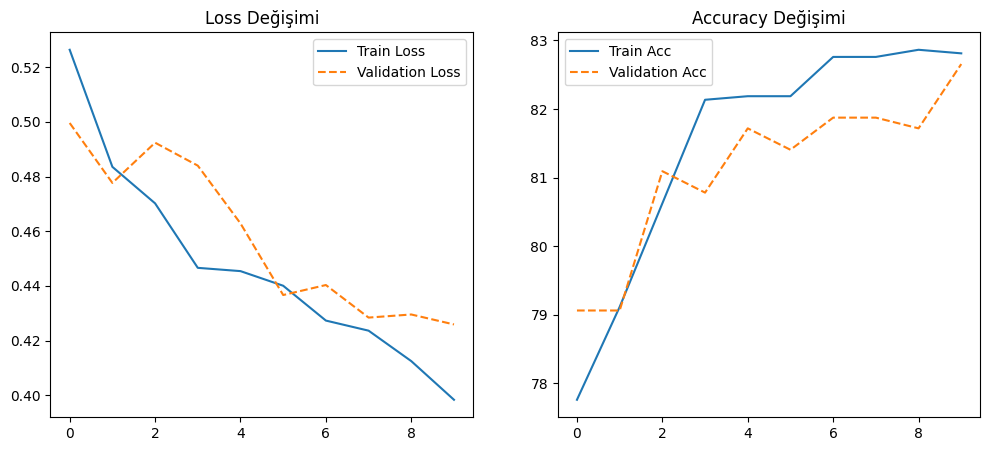

In [10]:
plt.figure(figsize=(12, 5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title('Loss Değişimi')
plt.legend()

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc', linestyle='--')
plt.title('Accuracy Değişimi')
plt.legend()

plt.show()

Test seti üzerinde tahminler yapılıyor...
----------------------------------------
Final Test Sonuçları:
Accuracy (Doğruluk) : %86.88
F1 Score            : 0.9198
ROC-AUC Score       : 0.8732
----------------------------------------

Detaylı Sınıflandırma Raporu:

                    precision    recall  f1-score   support

      Sağlıklı (0)       0.76      0.55      0.64       134
Hastalık Riski (1)       0.89      0.95      0.92       506

          accuracy                           0.87       640
         macro avg       0.82      0.75      0.78       640
      weighted avg       0.86      0.87      0.86       640



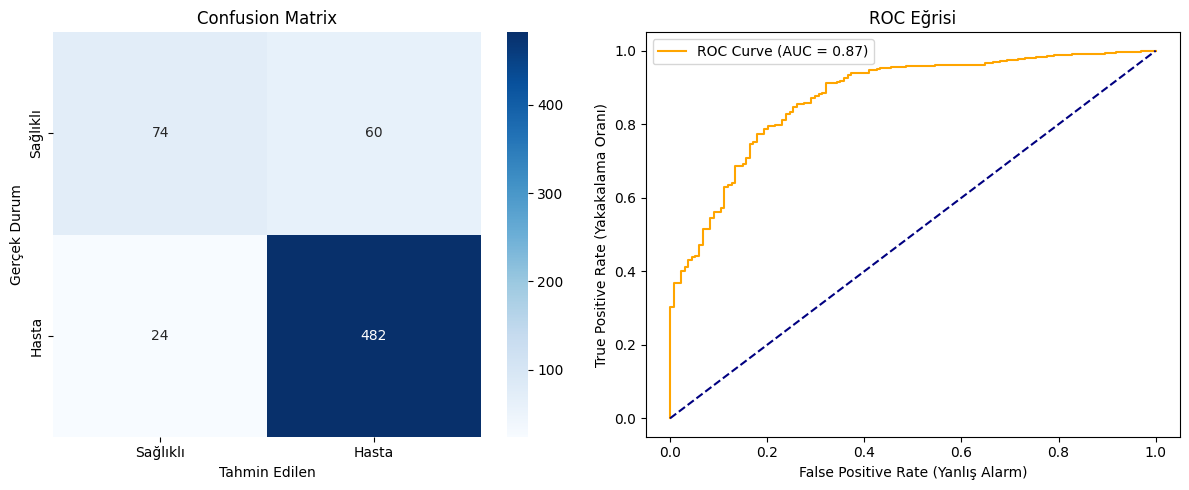

In [11]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Listeler: Gerçek etiketleri ve modelin tahminlerini burada toplayacağız
y_true = []       # Gerçek etiketler (0 veya 1)
y_pred = []       # Modelin tahmini (0 veya 1)
y_probs = []      # Modelin "Hastalık Var (1)" deme olasılığı (0.0 - 1.0 arası)

model.eval() # Modeli değerlendirme moduna al
print("Test seti üzerinde tahminler yapılıyor...")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device) # GPU/CPU'ya taşı
        
        # Model çıktısı (Logits)
        outputs = model(images)
        
        # 1. Olasılıkları Hesapla (Softmax kullanarak)
        # outputs boyutu: [Batch_Size, 2] -> (Sınıf 0 skoru, Sınıf 1 skoru)
        probs = torch.softmax(outputs, dim=1)
        
        # Sınıf 1 (Hastalık Var) olma olasılığını al
        prob_positive = probs[:, 1]
        
        # 2. Tahmin edilen sınıfı (0 veya 1) belirle
        _, predicted = torch.max(outputs, 1)
        
        # Sonuçları listelere ekle (CPU'ya alıp numpy array'e çeviriyoruz)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(prob_positive.cpu().numpy())

# --- PERFORMANS METRİKLERİ HESAPLAMA ---

# 1. Accuracy (Doğruluk)
acc = accuracy_score(y_true, y_pred)

# 2. F1 Score (Dengesiz veri setleri için kritiktir)
f1 = f1_score(y_true, y_pred)

# 3. ROC - AUC Score (Modelin ayırt etme gücü)
try:
    auc = roc_auc_score(y_true, y_probs)
except ValueError:
    auc = 0.0 # Eğer test setinde tek bir sınıf varsa hata verebilir
    print("Uyarı: ROC-AUC hesaplanamadı (Test setinde sadece tek sınıf olabilir).")

print("-" * 40)
print(f"Final Test Sonuçları:")
print(f"Accuracy (Doğruluk) : %{acc * 100:.2f}")
print(f"F1 Score            : {f1:.4f}")
print(f"ROC-AUC Score       : {auc:.4f}")
print("-" * 40)

# Detaylı Sınıflandırma Raporu
print("\nDetaylı Sınıflandırma Raporu:\n")
print(classification_report(y_true, y_pred, target_names=['Sağlıklı (0)', 'Hastalık Riski (1)']))

# --- GÖRSELLEŞTİRME ---
plt.figure(figsize=(12, 5))

# 1. Confusion Matrix (Karmaşıklık Matrisi)
cm = confusion_matrix(y_true, y_pred)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sağlıklı', 'Hasta'], yticklabels=['Sağlıklı', 'Hasta'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Durum')

# 2. ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # Rastgele tahmin çizgisi
plt.xlabel('False Positive Rate (Yanlış Alarm)')
plt.ylabel('True Positive Rate (Yakakalama Oranı)')
plt.title('ROC Eğrisi')
plt.legend()

plt.tight_layout()
plt.show()